In [1]:
import spectre as se
import spectre
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
import scipy as sp

import sys
sys.path.insert(1, '../quantarhei')
import quantarhei as qr

#import spectre.novibs as senv
import spectre.full as sef
import spectre.spectroscopy.abs_spectroscopy as abss
#from spectre.spectroscopy.spec_utils import iterate_parameter

from spectre.matplotlib_latex import *
plt_latex()

from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator
from matplotlib import cm

np.set_printoptions(precision=5, linewidth=370, suppress=True)

In [7]:
pp = dict(
    E = [0, 0.83, 1.0],
    d = [0,0.4,-0.3],
    N = [3,4,4],
    omega = 0.15,
    alpha = 0.1,
    xlim = 2.5,
    ylim=(-0.1,1.6),
)

In [369]:
pp = dict(
    E = [0, 14000, 15000],
    d = [0,0.1,0.1],
    N = [1,4,4],
    omega = 1500,
    alpha = 750,
    xlim = 2.5,
    ylim=(12000, 20000),
)

In [3]:
hbar = 1

def direct_sum(x, y):
    assert (type(x) == np.ndarray) and (type(y) == np.ndarray)
    return np.kron(x, np.eye(*x.shape,dtype=np.float64)) + np.kron(np.eye(*y.shape,dtype=np.float64), y)

def add_block(*inp):
    return sp.linalg.block_diag(*inp)

def add_to_diagonal(x, a):
    assert type(x) == np.ndarray
    return x + np.eye(*x.shape,dtype=np.float64)*a

def gen_offdiag_block(Na, Nb):
    indices_b = np.arange(Nb)
    return np.eye(Na, Nb, k=1,dtype=np.float64) * np.sqrt(indices_b) + np.eye(Na, Nb, k=-1,dtype=np.float64) * np.sqrt(indices_b + 1)

def gen_diag_block(N, omega, hr):
    elvib = np.identity(N,dtype=np.float64) * ((np.arange(N) + 1/2) * hbar * omega) 
    disp_diag = np.identity(N,dtype=np.float64) * hbar * omega                         ### <- what is this ???
    disp_offdiag = - gen_offdiag_block(N, N) * np.sqrt(hr) * hbar * omega
    return elvib  + disp_offdiag #+ disp_diag
    
#####

def get_lho_ham(n):
    one = np.identity(n)
    s = np.arange(0,n)
    return one * (s + 1/2) * pp['omega']


def direct_sum(a,b):
    assert len(a.diagonal()) == len(b)

    tot_mat_a = sp.linalg.block_diag(*[ai * np.identity(x.shape[0]) + x for ai,x in zip(a.diagonal(),b)])
    print(tot_mat_a)
    
    tot_dim = [x.shape[0] for x in b]
    tot_mat_b = sp.linalg.block_diag(*b)

    return tot_mat_a + tot_mat_b

In [8]:
Eg,Ey,Ex = pp['E']
Ng, Ny, Nx = pp['N']
omega1 = pp['omega']
u, hr_y1, hr_x1 = np.array(pp['d'])**2 /2
alpha1 = pp['alpha']

H_diag_g1 = gen_diag_block(Ng, omega1, 0)
H_diag_y1 = gen_diag_block(Ny, omega1, hr_y1)
H_diag_x1 = gen_diag_block(Nx, omega1, hr_x1)

H_offdiag_yx1 = gen_offdiag_block(Ny, Nx) * alpha1 / np.sqrt(2)

H1 = add_to_diagonal(H_diag_g1, Eg)
H2 = np.block([[add_to_diagonal(H_diag_y1, Ey), H_offdiag_yx1],[H_offdiag_yx1.T, add_to_diagonal(H_diag_x1, Ex)]])
H_S = add_block(H1, H2)

###

xax = np.linspace(-pp['xlim'],pp['xlim'],1001)
x = xax
pot = np.identity(3)[:,:,None] * (x[None,:] - np.array(pp['d'])[:,None])**2 * pp['omega']/2 + (np.identity(3) * pp['E'])[:,:,None]
pot[1,2,:] = x * pp['alpha']
pot[2,1,:] = x * pp['alpha']


###

b2 = [d * np.identity(n) for d, n  in zip(pp['d'], pp['N'])]
ds = add_block(*b2)

lhos = add_block(*[get_lho_ham(n) for n in pp['N']])
ham0 = lhos + add_block(*[np.identity(n) * e for e, n in zip(pp['E'], pp['N'])])

Text(0.5, 0, 'coordinate $\\hat{Q}_{V1}$')

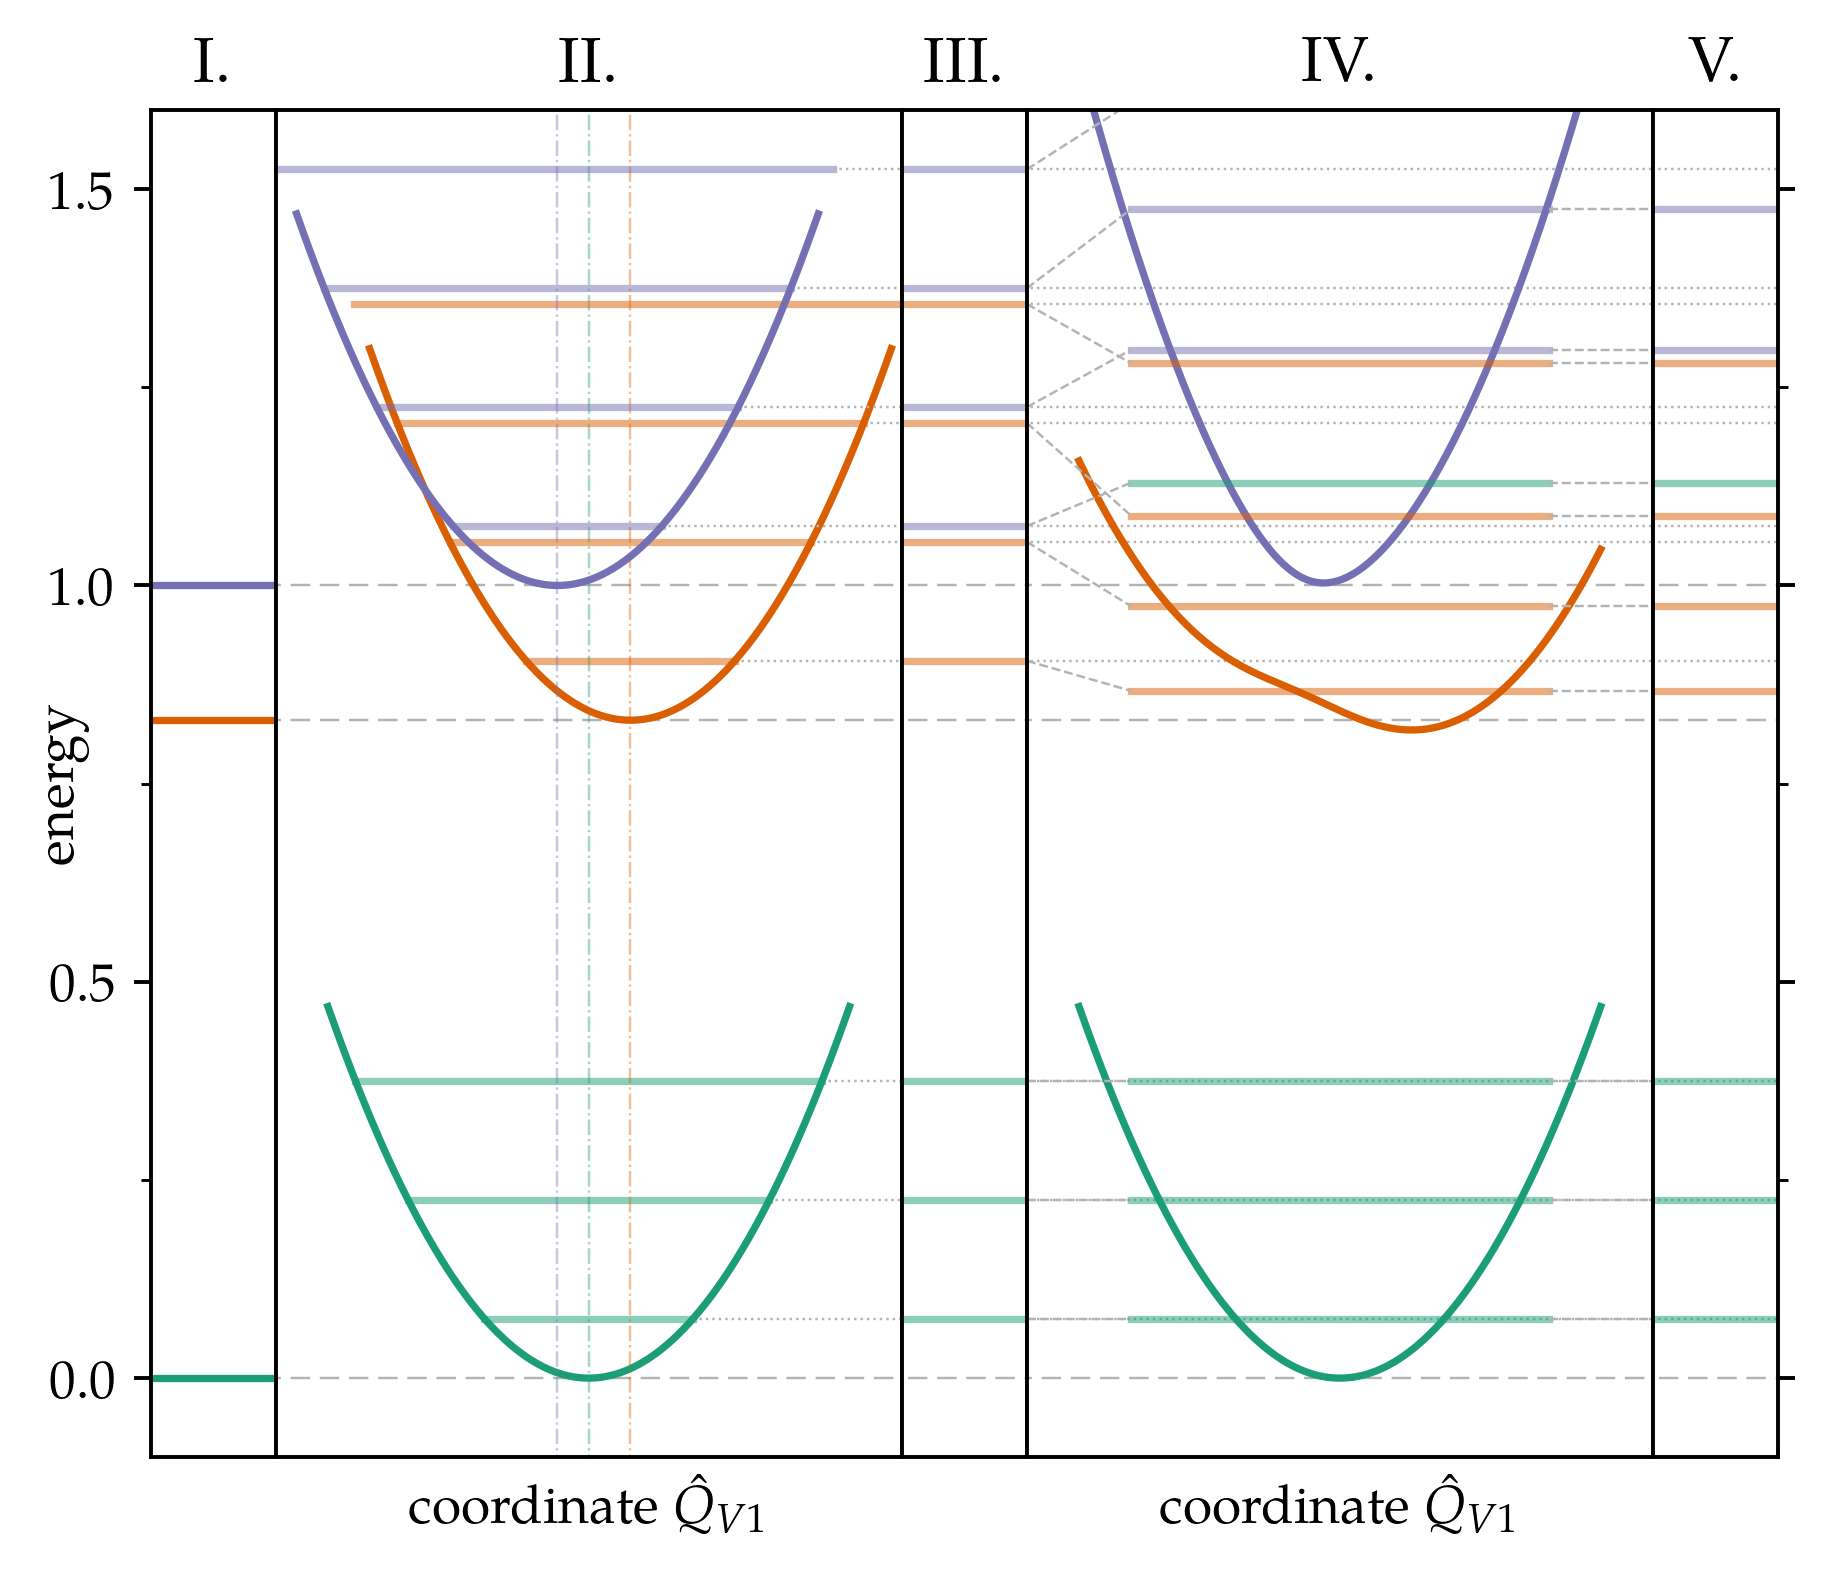

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(6,5), dpi=350, width_ratios=(1, 5, 1, 5, 1), sharey=True)

plt.subplots_adjust(hspace=0, wspace=0)
cyc = get_color_linestyle_cycler()

cols = list()
for i in range(3):
    cols.append(next(cyc))

for g in ax:
    pars = dict(labelbottom=False, labeltop=False, labelleft=False, labelright=False,
                bottom=False,           top=False,      left=False,      right=False,)
    g.tick_params(which='both', **pars)
    
    g.yaxis.set_major_locator(MaxNLocator(nbins=4))
    g.yaxis.set_minor_locator(AutoMinorLocator(2))
    g.xaxis.set_minor_locator(AutoMinorLocator(4))

ax[0].tick_params(which='both', left=True, labelleft=True)
ax[-1].tick_params(which='both', right=True)


### id 0

cyc = get_color_linestyle_cycler()
pars11 = dict()
pars1x = dict(ls=(4,(8,4)), color='0.7', linewidth=0.5)

for e in pp['E']:
    for j in range(len(ax)):
        if j == 0:
            ax[j].plot([0,1], [e,e], **next(cyc), **pars11)
        else:
            ax[j].plot([-5,5], [e,e], **pars1x)


### id 1

cyc = get_color_linestyle_cycler()
pars21 = dict(alpha=0.5)
pars2x = dict(linestyle=':', c='0.7', lw=0.5)

for i, e in enumerate(pp['E']):
    col = next(cyc)
    d = pp['d'][i]
    e = pp['E'][i]
    om = pp['omega']

    for j in range(len(ax)):
        if j == 1:
            for k in range(pp['N'][i]):
                ke = e + om * (k + 1/2)
                lim = np.sqrt(2*k + 1)
                ax[j].plot([-lim +d , lim +d], [ke, ke], **col, **pars21)
                ax[j].plot([lim +d,5], [ke,ke], **pars2x)
                
            ax[j].plot(xax+d, e + om /2 * (xax)**2, **col, **pars11)
        else:
            pass

    ax[1].plot([d,d],[-1,100000], linestyle='-.', alpha=0.4, lw=0.5)


### id 2
cyc = get_color_linestyle_cycler()

for i, e in enumerate(pp['E']):
    col = next(cyc)
    d = pp['d'][i]
    e = pp['E'][i]
    om = pp['omega']

    for j in range(len(ax)):
        for k in range(pp['N'][i]):
            ke = e + om * (k + 1/2)
            if j == 2:
                ax[j].plot([-1 , 1], [ke, ke], **col, **pars21)
                
            elif j > 2:
                ax[j].plot([-5,5], [ke,ke], **pars2x)


### id 3

cyc = get_color_linestyle_cycler()
pars3x = dict(linestyle='--', c='0.7', lw=0.5)

ev, dmat = np.linalg.eigh(H_S)
evs, dmats = np.linalg.eigh(np.transpose(pot, [2,1,0]))

keys = np.argmax((dmat**2), axis=1)
ng, ny, nx = pp['N']
keys_y = keys[ng:ng+ny]
keys_x = keys[ng+ny:]

for i, e in enumerate(pp['E']):
    d = pp['d'][i]
    e = pp['E'][i]
    om = pp['omega']
    
    ax[3].plot(xax, evs[:,i])

for i, e in enumerate(ev):
    if i in keys_y:
        col = cols[1]
    elif i in keys_x:
        col = cols[2]
    else:
        col = cols[0]

    xlim = pp['xlim']
    ax[3].plot([-xlim+1/2 , xlim-1/2], [e, e], **col, **pars21)
    ax[4].plot([0,1],[e,e], **col, **pars21)
    ax[3].plot([xlim-1/2, 5], [e,e], **pars3x)

    ax[3].plot([-3,-xlim+1/2], [ham0.diagonal()[np.argsort(keys)][i],e], **pars3x)


ax[0].set_ylim(*pp['ylim'])

ax[0].set_xlim(0,1)
ax[1].set_xlim(-3,3)
ax[2].set_xlim(0,1)
ax[3].set_xlim(-3,3)
ax[4].set_xlim(0,1)

ax[0].set_ylabel(r'energy',labelpad=-8)

ax[0].set_title(r'I.')
ax[1].set_title(r'II.')
ax[2].set_title(r'III.')
ax[3].set_title(r'IV.')
ax[4].set_title(r'V.')

ax[1].set_xlabel(r'coordinate $\hat{Q}_{V1}$')
ax[3].set_xlabel(r'coordinate $\hat{Q}_{V1}$')

# ax0.set_xlabel(r'frequency [cm$^{-1}$]')
# ax0.set_ylabel(r'angle [deg]')
# ax1.set_ylabel(r'abs. [a.u.]')
# ax2.set_ylabel(r'\parbox{40mm}{\centering angle [deg]}')
# ax4.set_ylabel(r'residuum')

# for i in [1,3]:
#     ax[i].set_xlim(-pp['xlim'],pp['xlim'])



In [425]:
keys = np.argwhere((dmat**2).T == (dmat**2).max(axis=1))
np.argsort(keys[:,1])

array([0, 1, 2, 3, 7, 4, 6, 5, 8], dtype=int64)

In [426]:
keys = np.argmax((dmat**2), axis=1)
np.argsort(keys)

array([0, 1, 2, 3, 5, 7, 6, 4, 8], dtype=int64)

In [432]:
(dmat**2)[3]

array([ 0.     ,  0.01752,  0.04589,  0.42265,  0.01928,  0.31957,  0.08735,  0.0119 ,  0.07585])

In [434]:
np.dot(dmat.T, np.dot(H_S, dmat))

array([[ 0.075  ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.87581,  0.     , -0.     , -0.     ,  0.     ,  0.     ,  0.     , -0.     ],
       [ 0.     ,  0.     ,  0.96423,  0.     , -0.     , -0.     , -0.     , -0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  1.09699, -0.     ,  0.     , -0.     , -0.     , -0.     ],
       [ 0.     , -0.     ,  0.     , -0.     ,  1.11018, -0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     , -0.     ,  0.     , -0.     ,  1.2631 ,  0.     ,  0.     , -0.     ],
       [ 0.     ,  0.     , -0.     , -0.     ,  0.     ,  0.     ,  1.31138, -0.     , -0.     ],
       [ 0.     ,  0.     , -0.     , -0.     ,  0.     ,  0.     , -0.     ,  1.45163, -0.     ],
       [ 0.     , -0.     ,  0.     , -0.     ,  0.     , -0.     , -0.     , -0.     ,  1.64669]])

In [435]:
H_S

array([[ 0.075  ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.905  , -0.02121,  0.     ,  0.     ,  0.     ,  0.07071,  0.     ,  0.     ],
       [ 0.     , -0.02121,  1.055  , -0.03   ,  0.     ,  0.07071,  0.     ,  0.1    ,  0.     ],
       [ 0.     ,  0.     , -0.03   ,  1.205  , -0.03674,  0.     ,  0.1    ,  0.     ,  0.12247],
       [ 0.     ,  0.     ,  0.     , -0.03674,  1.355  ,  0.     ,  0.     ,  0.12247,  0.     ],
       [ 0.     ,  0.     ,  0.07071,  0.     ,  0.     ,  1.075  , -0.06364,  0.     ,  0.     ],
       [ 0.     ,  0.07071,  0.     ,  0.1    ,  0.     , -0.06364,  1.225  , -0.09   ,  0.     ],
       [ 0.     ,  0.     ,  0.1    ,  0.     ,  0.12247,  0.     , -0.09   ,  1.375  , -0.11023],
       [ 0.     ,  0.     ,  0.     ,  0.12247,  0.     ,  0.     ,  0.     , -0.11023,  1.525  ]])

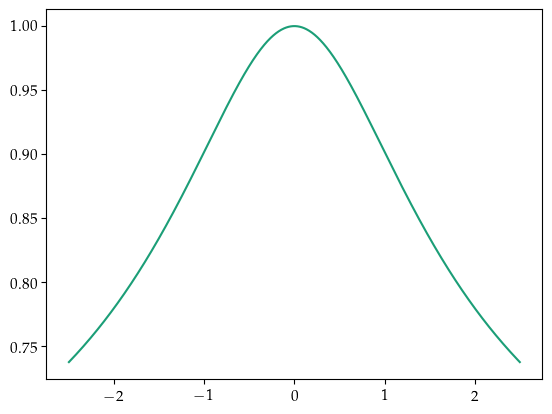

In [270]:
plt.plot(xax, (dmats**2)[:,1,1])

In [272]:
np.sqrt(2*ham0 +1)

array([[ 1.14018,  1.     ,  1.     ,  1.     ,  1.     ,  1.     ,  1.     ,  1.     ,  1.     ],
       [ 1.     ,  1.66132,  1.     ,  1.     ,  1.     ,  1.     ,  1.     ,  1.     ,  1.     ],
       [ 1.     ,  1.     ,  1.83303,  1.     ,  1.     ,  1.     ,  1.     ,  1.     ,  1.     ],
       [ 1.     ,  1.     ,  1.     ,  1.98997,  1.     ,  1.     ,  1.     ,  1.     ,  1.     ],
       [ 1.     ,  1.     ,  1.     ,  1.     ,  2.13542,  1.     ,  1.     ,  1.     ,  1.     ],
       [ 1.     ,  1.     ,  1.     ,  1.     ,  1.     ,  1.81659,  1.     ,  1.     ,  1.     ],
       [ 1.     ,  1.     ,  1.     ,  1.     ,  1.     ,  1.     ,  1.97484,  1.     ,  1.     ],
       [ 1.     ,  1.     ,  1.     ,  1.     ,  1.     ,  1.     ,  1.     ,  2.12132,  1.     ],
       [ 1.     ,  1.     ,  1.     ,  1.     ,  1.     ,  1.     ,  1.     ,  1.     ,  2.25832]])

In [173]:
x = np.linspace(-2,2,101)
pot = np.identity(3)[:,:,None] * (x[None,:] - np.array(pp['d'])[:,None])**2 * pp['omega']/2 + (np.identity(3) * pp['E'])[:,:,None]
pot[1,2,:] = x * pp['alpha']
pot[2,1,:] = x * pp['alpha']

evs, dmats = np.linalg.eigh(np.transpose(pot, [2,1,0]))

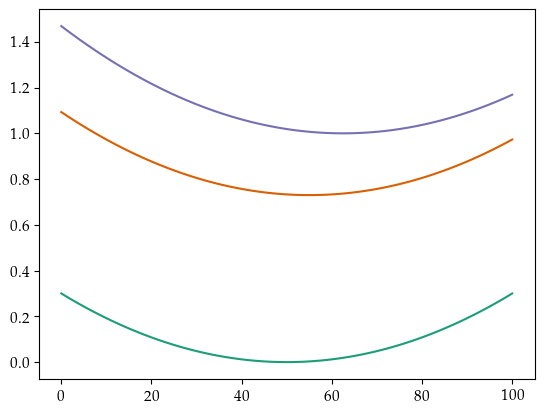

In [174]:
for i in range(3):
    plt.plot(pot[i,i])

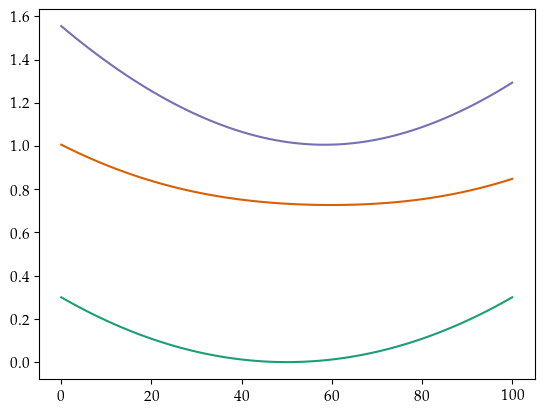

In [175]:
for i in range(3):
    plt.plot(evs[:,i])

In [265]:
import sympy

In [ ]:
sympy.symbols